In [2]:
from model_helper import ModelHelper
import load_data as ld
from colors import colors_light, colors_dark

In [5]:
dataset = ld.load_dataset('data')
print(len(dataset))

from collections import Counter

def get_class_counts(dataset):
    # Die Zielklassen (labels) der Bilder
    class_counts = Counter(dataset.targets)
    
    # Mappe die Indizes auf Klassennamen
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    
    # Zeige die Anzahl der Bilder pro Klasse an
    for class_idx, count in class_counts.items():
        print(f"Class '{idx_to_class[class_idx]}' has {count} images.")

# Lade das Dataset
get_class_counts(dataset)

7590
Class 'alzheimers_dataset' has 2500 images.
Class 'normal' has 2699 images.
Class 'parkinsons_dataset' has 2391 images.


In [109]:
import torch
from torch.utils.tensorboard import SummaryWriter

model = ModelHelper.load_model("models/ViT_20241105_1549-98.68.pth").model.to("cpu")

writer = SummaryWriter('torchlogs/ResNet')
sample_input = torch.randn((1, 3, 224, 224))
traced_model = torch.jit.trace(model, sample_input, strict=False)

writer.add_graph(traced_model, sample_input)
writer.close()

In [6]:
import torch
from torch.utils.tensorboard import SummaryWriter

model = ModelHelper.load_model("models/ResNet50_20241111_1559-95.43.pth").model.to("cpu")

writer = SummaryWriter('../torchlogs/ResNet')
sample_input = torch.randn((1, 3, 224, 224))
traced_model = torch.jit.trace(model, sample_input, strict=False)

writer.add_graph(traced_model, sample_input)
writer.close()


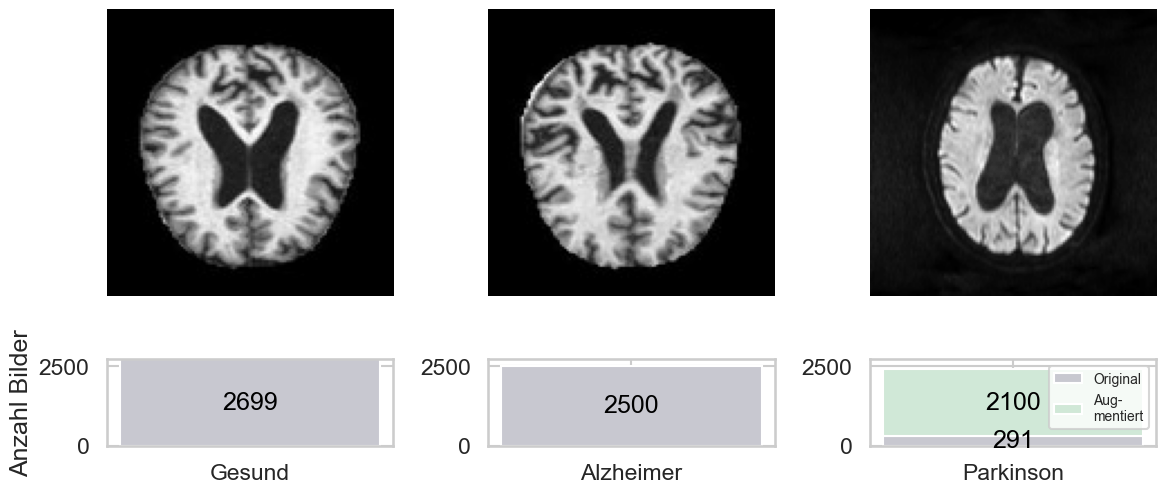

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

class_counts = {'Gesund': 2699, 'Alzheimer': 2500, 'Parkinson': 2391}
augmented_counts = {'Gesund': 0, 'Alzheimer': 0, 'Parkinson': 2100} 
images = {
    'normal': "../src/data/normal/non_140.jpg",
    'alzheimers_dataset': "../src/data/alzheimers_dataset/mild_23.jpg",
    'parkinsons_dataset': "../src/data/parkinsons_dataset/sDW_SSh_030.png"
}
max_count = max(class_counts.values())

bar_data = []
for label in class_counts.keys():
    total_count = class_counts[label]
    aug_count = augmented_counts[label]
    orig_count = total_count - aug_count
    bar_data.append({'Klasse': label, 'Typ': 'Original', 'Anzahl': orig_count})
    if aug_count > 0:
        bar_data.append({'Klasse': label, 'Typ': 'Augmentiert', 'Anzahl': aug_count})

bar_df = pd.DataFrame(bar_data)

fig, axes = plt.subplots(2, 3, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 0.2]})

# Erste Zeile: Bilder nebeneinander anzeigen
for idx, (label, img_path) in enumerate(images.items()):
    img = plt.imread(img_path)
    ax = axes[0, idx]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

# Zweite Zeile: Stacked Bar-Chart
for idx, label in enumerate(class_counts.keys()):
    class_data = bar_df[bar_df['Klasse'] == label]
    
    original_data = class_data[class_data['Typ'] == 'Original']
    augmented_data = class_data[class_data['Typ'] == 'Augmentiert']
    
    original_bar = axes[1, idx].bar(label, original_data['Anzahl'].values, label='Original', color=colors_light['gray'])
    augmented_bar = axes[1, idx].bar(label, augmented_data['Anzahl'].values, bottom=original_data['Anzahl'].values, label='Aug-\nmentiert', color=colors_light['green'])
    
    # Text hinzufügen: Anzahl innerhalb der Balken
    for bar in original_bar:
        height = bar.get_height()
        axes[1, idx].text(bar.get_x() + bar.get_width() / 2, height / 2, f'{int(height)}', ha='center', va='center', color='black')
    for bar in augmented_bar:
        height = bar.get_height()
        axes[1, idx].text(bar.get_x() + bar.get_width() / 2, original_data['Anzahl'].values + height / 2, f'{int(height)}', ha='center', va='center', color='black')
    
    axes[1, idx].set_ylim(0, max_count)


axes[1, 0].set_ylabel('Anzahl Bilder')  # Nur links setzen

plt.tight_layout()
plt.legend(prop={'size': 10})

plt.savefig('../images/dataset_overview.png', transparent=True)
plt.show()

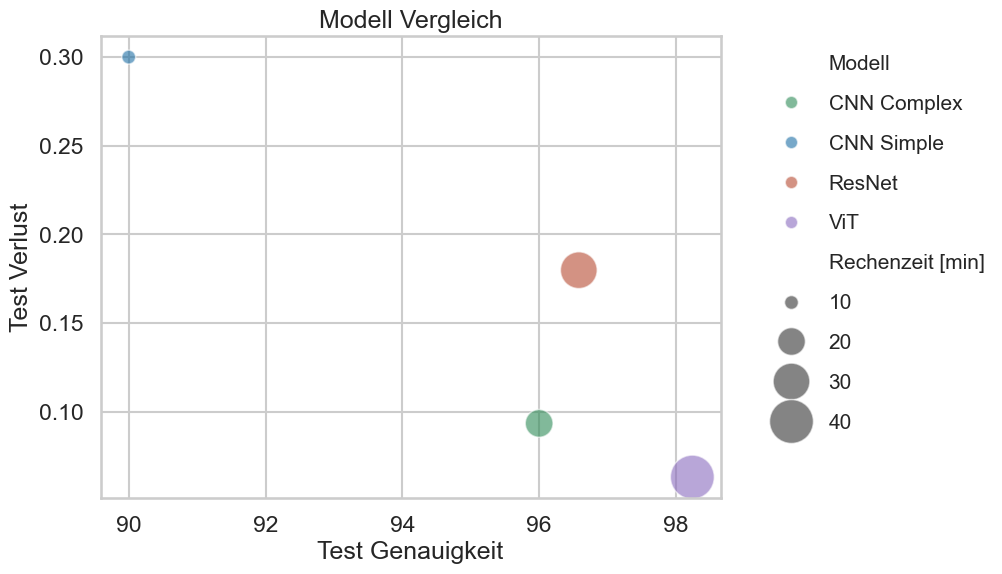

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_context("talk")

# TODO richtige daten
models = ['CNN Complex', 'CNN Simple', 'ResNet', 'ViT']
test_accuracy = [96, 90, 96.58, 98.24]
test_loss = [0.0934, 0.30, 0.1798, 0.0631]
computation_time = [20, 10, 30, 40] # TODO in richtige Einheit umwandlen

df = pd.DataFrame({
    'Modell': models,
    'Test Genauigkeit': test_accuracy,
    'Test Verlust': test_loss,
    'Rechenzeit [min]': computation_time
})

# Plot
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(data=df, x='Test Genauigkeit', y='Test Verlust', size='Rechenzeit [min]', sizes=(100, 1000), alpha=0.6, hue='Modell', palette=list(colors_dark.values()))

plt.xlabel('Test Genauigkeit')
plt.ylabel('Test Verlust')
plt.title('Modell Vergleich')

plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=15, labelspacing=1, frameon=False)

plt.savefig('../images/model_comparison.png', transparent=True, bbox_inches='tight')
plt.show()